In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import csv
import warnings
from scipy.interpolate import CubicSpline

In [2]:
warnings.filterwarnings("ignore")

In [3]:
# Cubic spline Interpolation data inputation method
def four_ends_filler(column):
    if  pd.api.types.is_numeric_dtype(column):
        for i in range(4):
            column = first_filler(column, i, len(column) - 1 - i)
            column = last_filler(column, i, len(column) - 1 - i)
    return column

def four_ends_linear_filler(column):
    if  pd.api.types.is_numeric_dtype(column):
        size = len(column) - 1
        column = first_filler(column, 0, size)
        column = last_filler(column, 0, size)
        for i in range(0, 4):
            value = column.at[i]
            if i > 0 and (pd.isnull(value) or np.isnan(value) or (value == '')):
                start_first = prev_valid_index(column, i)
                end_first = next_valid_index(column, i)
                gap = list(range(start_first + 1, end_first))
                linear_a = (column.at[end_first] - column.at[start_first])/(end_first - start_first)
                linear_b = column.at[start_first] - linear_a*start_first
                column.at[i] = linear_a*i + linear_b
            value = column.at[size - 4 + i]
            if i > 0 and (pd.isnull(value) or np.isnan(value) or (value == '')):
                start_last = prev_valid_index(column, size - 4 + i)
                end_last = next_valid_index(column, size - 4 + i)
                gap = list(range(start_last + 1, end_last))
                linear_a = (column.at[end_last] - column.at[start_last])/(end_last - start_last)
                linear_b = column.at[start_last] - linear_a*start_last
                column.at[size - 4 + i] = linear_a*i + linear_b
    return column

def first_filler(column, init, end):
    if pd.isnull(column.at[init]) or np.isnan(column.at[init]):
        first_valid_index = 0
        while first_valid_index <= end and (pd.isnull(column.at[first_valid_index]) or 
                                             np.isnan(column.at[first_valid_index])):
            first_valid_index += 1
        if first_valid_index > end:
            column.at[init] = 0.0
        else:
            column.at[init] = column.at[first_valid_index]
    return column
    
def last_filler(column, init, end):
    if pd.isnull(column.at[end]) or np.isnan(column.at[end]):
        last_valid_index = len(column) -1
        while last_valid_index >= init and (pd.isnull(column.at[last_valid_index]) or 
                                         np.isnan(column.at[last_valid_index])):
            last_valid_index -= 1
        if last_valid_index < init:
            column.at[end] = 0.0
        else:
            column.at[end] = column.at[last_valid_index]
    return column
  
def neareast_four_indexes(column, start, end):
    return prev_four_valid_indexes(column, start) + next_four_valid_indexes(column, end)

def prev_four_valid_indexes(column, pos):
    prev_index = pos
    index_prev_list = [0]*4
    size = len(column) - 1
    if pos > 0 and pos < size:
        for i in range(4):
            index_prev_list[3 - i] = prev_index
            prev_index -= 1
            while prev_index >= 0 and (pd.isnull(column.at[prev_index]) or np.isnan(column.at[prev_index])):
                prev_index -= 1
    return index_prev_list  

def next_four_valid_indexes(column, pos):
    next_index = pos
    index_next_list = [0]*4
    size = len(column) - 1
    if pos > 0 and pos < size:
        for i in range(4):
            index_next_list[i] = next_index
            next_index += 1
            while next_index <= size and (pd.isnull(column.at[next_index]) or np.isnan(column.at[next_index])):
                next_index += 1
    return index_next_list  

def prev_valid_index(column, pos):
    prev_index = pos
    size = len(column) -1
    if pos >= 0 and pos < size:
        prev_index -= 1
        while prev_index >= 0 and (pd.isnull(column.at[prev_index]) or np.isnan(column.at[prev_index])):
            prev_index -= 1
    return prev_index  

def next_valid_index(column, pos):
    next_index = pos
    size = len(column) -1
    if pos >= 0 and pos < size:
        next_index += 1
        while next_index <= size and (pd.isnull(column.at[next_index]) or np.isnan(column.at[next_index])):
            next_index += 1
    return next_index

def interpolating_polynomial(nearest_indexes, nearest_values):
    coeffs = np.polyfit(nearest_indexes, nearest_values, len(nearest_indexes) - 1)
    return np.poly1d(coeffs)

def polynomial_filler(column):
    size = len(column) -1
    if column.isnull().any() and column.isna().any():
        for i, value in enumerate(column):
            if (i > 3 and i < size - 3) and (pd.isnull(value) or np.isnan(value) or (value == '')):
                nearest_values = []
                start = prev_valid_index(column, i)
                end = next_valid_index(column, i)
                gap = list(range(start + 1, end))
                nearest_indexes = neareast_four_indexes(column, start, end)
                print(nearest_indexes)
                for index in nearest_indexes:
                    nearest_values.append(column.at[index])
                print(nearest_values)
                polynomial = interpolating_polynomial(nearest_indexes, nearest_values)
                for x in gap:
                    column.at[x] = polynomial(x)
                plot_polynomial(polynomial, nearest_indexes[0], nearest_indexes[len(nearest_indexes) - 1], 50, gap, nearest_indexes)
    return column

def cubic_spline_filler(column):
    size = len(column) -1
    if column.isnull().any() and column.isna().any():
        for i, value in enumerate(column):
            if (i > 3 and i < size - 3) and (pd.isnull(value) or np.isnan(value) or (value == '')):
                nearest_values = []
                start = prev_valid_index(column, i)
                end = next_valid_index(column, i)
                gap = list(range(start + 1, end))
                nearest_indexes = neareast_four_indexes(column, start, end)
                print(nearest_indexes)
                for index in nearest_indexes:
                    nearest_values.append(column.at[index])
                print(nearest_values)
                cubic_spline = CubicSpline(nearest_indexes, nearest_values)
                for x in gap:
                    column.at[x] = cubic_spline(x)
                plot_polynomial(cubic_spline, nearest_indexes[0], nearest_indexes[len(nearest_indexes) - 1], 50, gap, nearest_indexes)
    return column

def plot_polynomial(polynomial, start, end, precision, interpolated_list, nearest_indexes):
    x = np.linspace(start, end, precision)
    y = polynomial(x)

    plt.figure()

    plt.plot(x, y)

    interpolated_x = interpolated_list  
    interpolated_y = polynomial(interpolated_x)
    plt.scatter(interpolated_x, interpolated_y, color='red')
    interpolated_x = nearest_indexes  
    interpolated_y = polynomial(interpolated_x)
    plt.scatter(interpolated_x, interpolated_y, color='green')

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Polynomial Plot')

    plt.show()

In [4]:
def read_csv_replace_missing_by_polynomial(file_path):
    with open(file_path, 'r') as f:
        
        df = pd.read_csv(file_path, skiprows=1)
        df = df.iloc[:, 2:-1]
        
        i = 0
        for col in df.columns: # Elimina missing values por médias e transforma em float
            if i > 2:
                df[col] = df[col].replace('-9999', np.nan)
                df[col] = df[col].replace('-', np.nan)
                df[col] = df[col].replace('', np.nan).astype(float)
                df[col] = four_ends_filler(df[col])
                df[col] = polynomial_filler(df[col]) 
            i += 1
        return df

In [5]:
df = read_csv_replace_missing_by_polynomial('idh.csv')
df = df.T
df
header = df.iloc[0]
df = df[1:]
df.columns = header
df

Estado,Acre,Alagoas,Amazonas,Amapá,Bahia,Ceará,Distrito Federal,Espírito Santo,Goiás,Maranhão,...,Paraná,Rio de Janeiro,Rio Grande do Norte,Rondônia,Roraima,Rio Grande do Sul,Santa Catarina,Sergipe,São Paulo,Tocantins
1980,0.506,0.41,0.608,0.582,0.515,0.44,0.751,0.673,0.66,0.405,...,0.7,0.733,0.444,0.595,0.679,0.744,0.734,0.477,0.728,0.465
1991,0.584,0.474,0.658,0.687,0.53,0.517,0.806,0.704,0.722,0.456,...,0.76,0.782,0.539,0.635,0.728,0.786,0.785,0.539,0.787,0.56
2012,0.701,0.651,0.691,0.707,0.678,0.701,0.825,0.758,0.744,0.648,...,0.772,0.762,0.695,0.694,0.738,0.763,0.792,0.684,0.812,0.71
2013,0.706,0.648,0.702,0.734,0.68,0.705,0.837,0.765,0.752,0.661,...,0.782,0.768,0.71,0.687,0.738,0.773,0.801,0.683,0.818,0.719
2014,0.715,0.666,0.706,0.725,0.694,0.71,0.836,0.772,0.757,0.663,...,0.788,0.78,0.723,0.692,0.744,0.779,0.807,0.696,0.825,0.737
2015,0.718,0.666,0.711,0.728,0.701,0.715,0.837,0.776,0.755,0.669,...,0.786,0.785,0.733,0.706,0.748,0.787,0.809,0.697,0.823,0.73
2016,0.723,0.68,0.711,0.733,0.705,0.722,0.847,0.779,0.764,0.68,...,0.797,0.789,0.732,0.715,0.752,0.789,0.814,0.697,0.835,0.734
2017,0.712,0.679,0.728,0.732,0.71,0.73,0.842,0.78,0.765,0.685,...,0.797,0.791,0.728,0.721,0.746,0.793,0.817,0.699,0.831,0.74
2018,0.733,0.689,0.718,0.741,0.71,0.739,0.845,0.788,0.771,0.686,...,0.805,0.805,0.739,0.73,0.76,0.797,0.819,0.71,0.837,0.749
2019,0.739,0.687,0.726,0.737,0.718,0.744,0.859,0.793,0.774,0.694,...,0.807,0.809,0.742,0.73,0.749,0.801,0.826,0.705,0.845,0.751


In [16]:
df['Ano'] = df.index
df = df.reset_index(drop=True)

missing_years = list(range(1981, 1991)) + list(range(1992, 2013))
for year in missing_years: 
    novo_ano = pd.Series({'Ano': year})
    df = df.append(novo_ano, ignore_index=True)
    
df['Ano'] = df['Ano'].astype(int)    
df = df.sort_values('Ano', ascending=True)
df = df.set_index('Ano')
df.to_csv('idh_para_interpolacao.csv', index=True)
df

,Acre,Alagoas,Amazonas,Amapá,Bahia,Ceará,Distrito Federal,Espírito Santo,Goiás,Maranhão,...,Paraná,Rio de Janeiro,Rio Grande do Norte,Rondônia,Roraima,Rio Grande do Sul,Santa Catarina,Sergipe,São Paulo,Tocantins
Ano,,,,,,,,,,,,,,,,,,,,,
1980,0.506,0.41,0.608,0.582,0.515,0.44,0.751,0.673,0.66,0.405,...,0.7,0.733,0.444,0.595,0.679,0.744,0.734,0.477,0.728,0.465
1981,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1982,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1983,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1984,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1985,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1986,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1987,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1988,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
def read_csv_replace_missing_by_polynomial_2(file_path):
    with open(file_path, 'r') as f:
        
        df = pd.read_csv(file_path)
        df = df.iloc[:, :-1]
        
        i = 0
        for col in df.columns: # Elimina missing values por médias e transforma em float
            if i > 0:
                df[col] = df[col].replace('-9999', np.nan)
                df[col] = df[col].replace('-', np.nan)
                df[col] = df[col].replace('', np.nan).astype(float)
                df[col] = four_ends_linear_filler(df[col])
                df[col] = cubic_spline_filler(df[col]) 
            i += 1
        return df

[0, 1, 2, 3, 11, 33, 34, 35]
[0.506, 0.513090909090909, 0.5201818181818182, 0.5272727272727272, 0.584, 0.701, 0.706, 0.715]


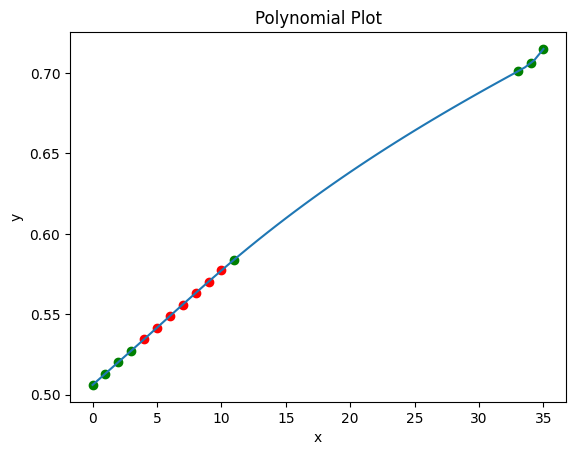

[8, 9, 10, 11, 33, 34, 35, 36]
[0.5631551710537493, 0.5702222497299789, 0.5771808175871652, 0.584, 0.701, 0.706, 0.715, 0.718]


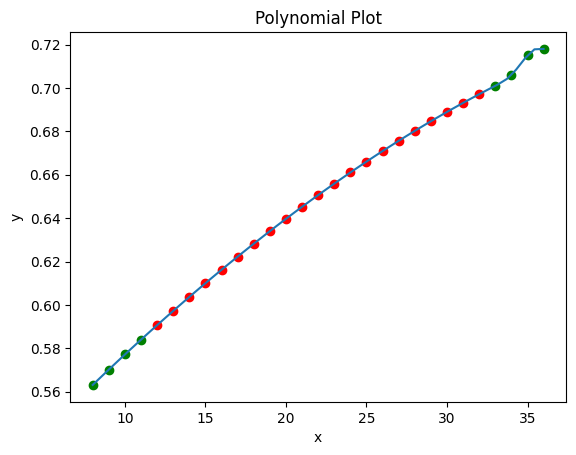

[0, 1, 2, 3, 11, 33, 34, 35]
[0.41, 0.4158181818181818, 0.4216363636363636, 0.42745454545454536, 0.474, 0.651, 0.648, 0.666]


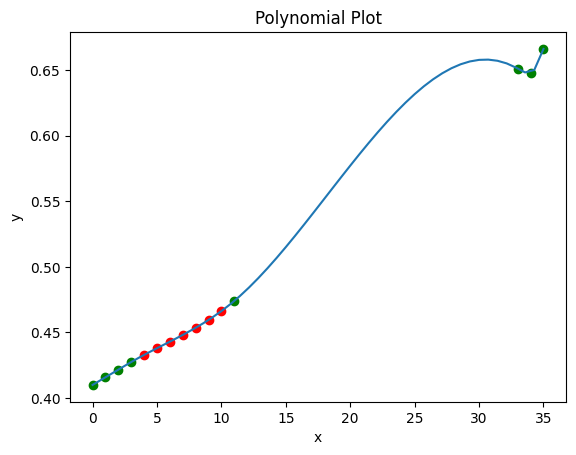

[8, 9, 10, 11, 33, 34, 35, 36]
[0.45352656255688634, 0.45951287180980804, 0.46626474246368366, 0.474, 0.651, 0.648, 0.666, 0.666]


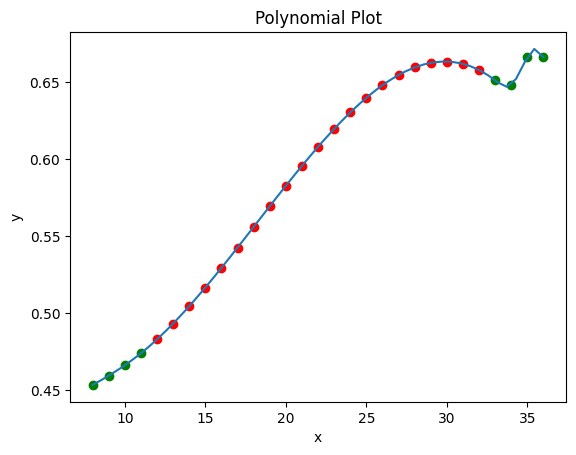

[0, 1, 2, 3, 11, 33, 34, 35]
[0.608, 0.6125454545454545, 0.6170909090909091, 0.6216363636363638, 0.658, 0.691, 0.702, 0.706]


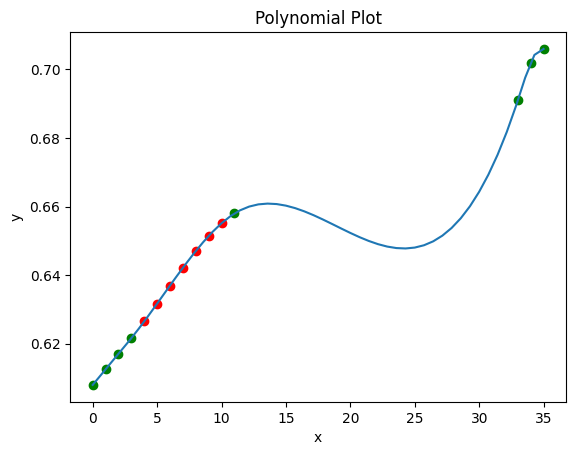

[8, 9, 10, 11, 33, 34, 35, 36]
[0.6470416822156285, 0.6514379916505869, 0.6551551749220278, 0.658, 0.691, 0.702, 0.706, 0.711]


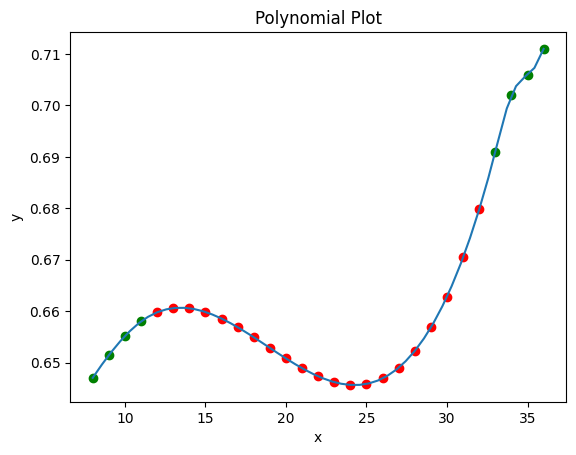

[0, 1, 2, 3, 11, 33, 34, 35]
[0.582, 0.5915454545454545, 0.6010909090909091, 0.6106363636363638, 0.687, 0.707, 0.734, 0.725]


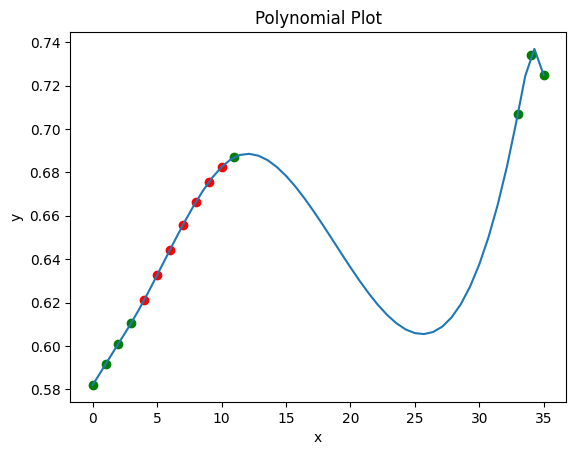

[8, 9, 10, 11, 33, 34, 35, 36]
[0.6662477063385155, 0.6753540830815161, 0.6824611370007647, 0.687, 0.707, 0.734, 0.725, 0.728]


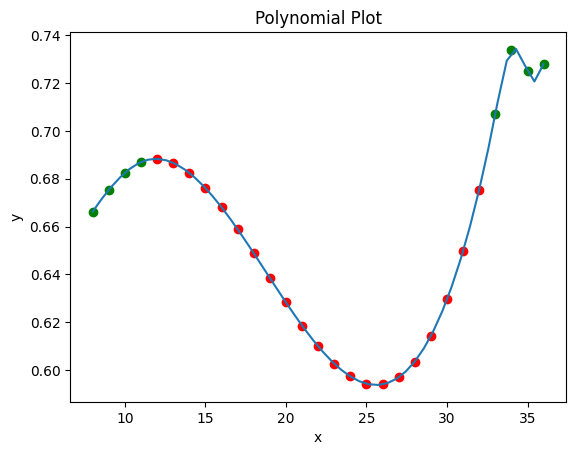

[0, 1, 2, 3, 11, 33, 34, 35]
[0.515, 0.5163636363636364, 0.5177272727272727, 0.5190909090909092, 0.53, 0.678, 0.68, 0.694]


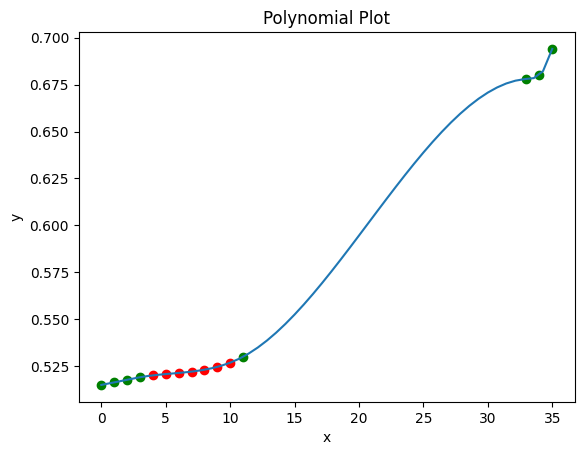

[8, 9, 10, 11, 33, 34, 35, 36]
[0.523088340099028, 0.524609069064696, 0.5268451127716898, 0.53, 0.678, 0.68, 0.694, 0.701]


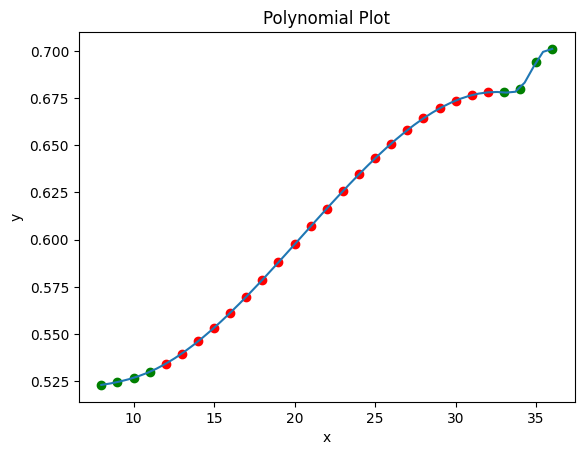

[0, 1, 2, 3, 11, 33, 34, 35]
[0.44, 0.447, 0.454, 0.461, 0.517, 0.701, 0.705, 0.71]


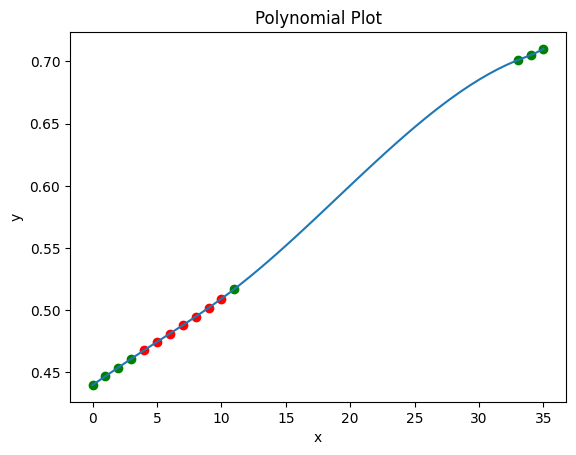

[8, 9, 10, 11, 33, 34, 35, 36]
[0.4948395206823946, 0.5019041498282788, 0.5092630651478744, 0.517, 0.701, 0.705, 0.71, 0.715]


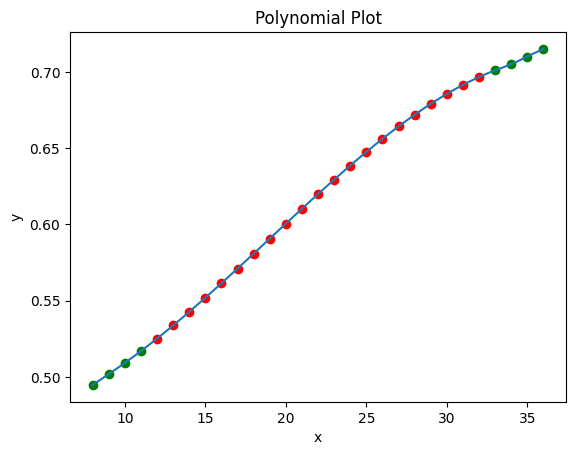

[0, 1, 2, 3, 11, 33, 34, 35]
[0.751, 0.756, 0.761, 0.766, 0.806, 0.825, 0.837, 0.836]


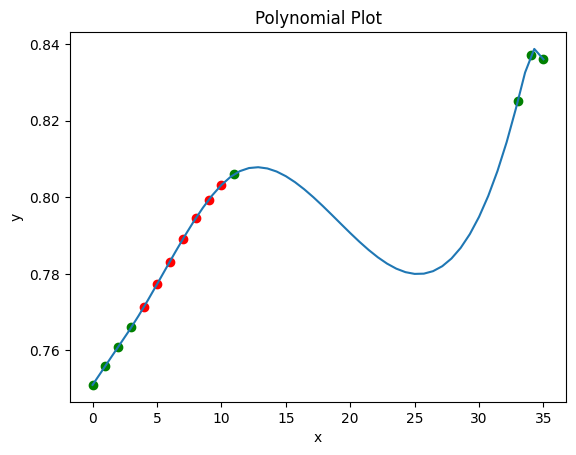

[8, 9, 10, 11, 33, 34, 35, 36]
[0.7944511212697662, 0.7992589222218177, 0.8031915526662298, 0.806, 0.825, 0.837, 0.836, 0.837]


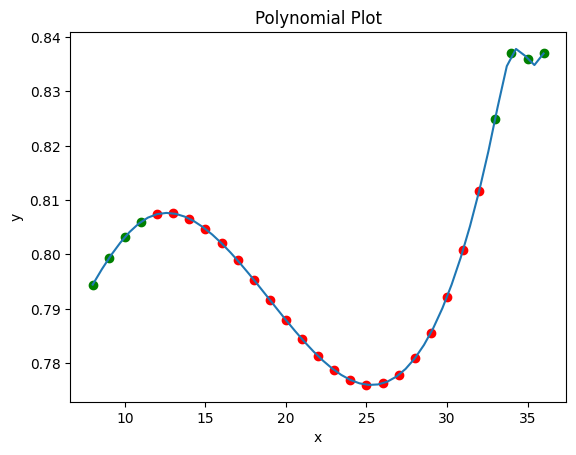

[0, 1, 2, 3, 11, 33, 34, 35]
[0.673, 0.6758181818181819, 0.6786363636363637, 0.6814545454545454, 0.704, 0.758, 0.765, 0.772]


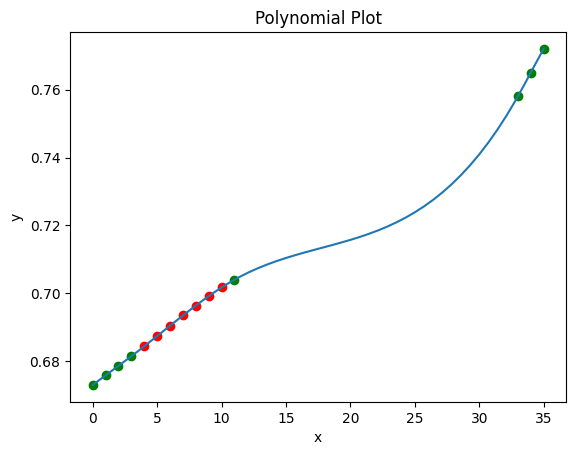

[8, 9, 10, 11, 33, 34, 35, 36]
[0.6963795964248005, 0.6991513234062693, 0.7017115201878618, 0.704, 0.758, 0.765, 0.772, 0.776]


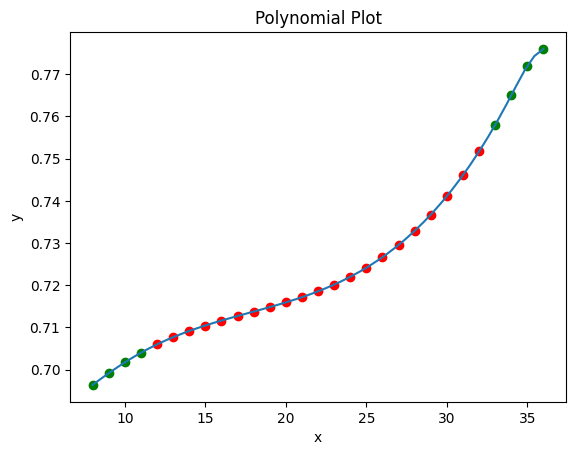

[0, 1, 2, 3, 11, 33, 34, 35]
[0.66, 0.6656363636363637, 0.6712727272727272, 0.6769090909090908, 0.722, 0.744, 0.752, 0.757]


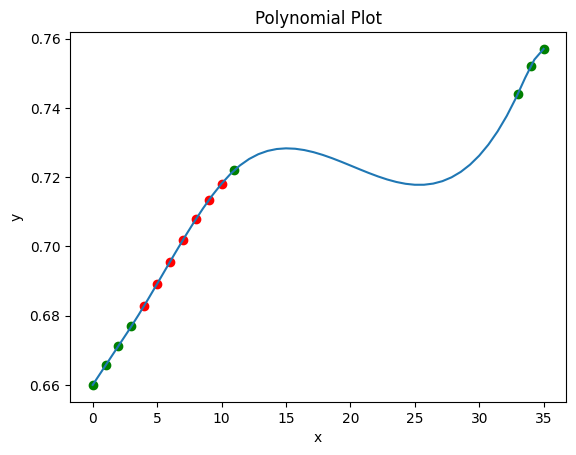

[8, 9, 10, 11, 33, 34, 35, 36]
[0.7077940744802853, 0.7132798940546837, 0.7180802173972402, 0.722, 0.744, 0.752, 0.757, 0.755]


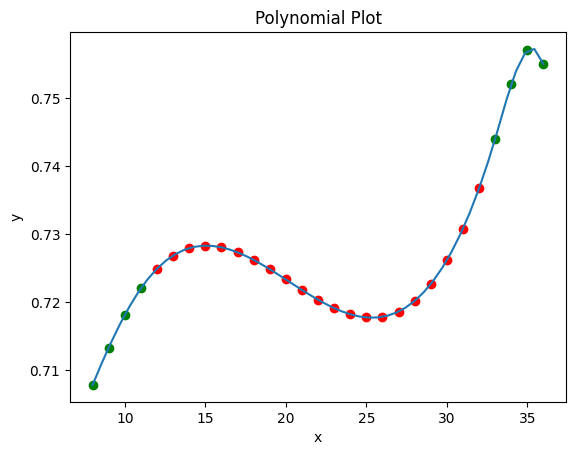

[0, 1, 2, 3, 11, 33, 34, 35]
[0.405, 0.4096363636363637, 0.4142727272727273, 0.41890909090909095, 0.456, 0.648, 0.661, 0.663]


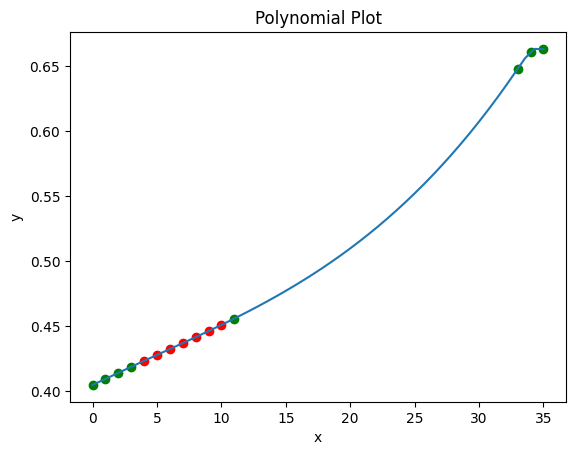

[8, 9, 10, 11, 33, 34, 35, 36]
[0.4417061037639107, 0.44636389788958875, 0.45111927487227105, 0.456, 0.648, 0.661, 0.663, 0.669]


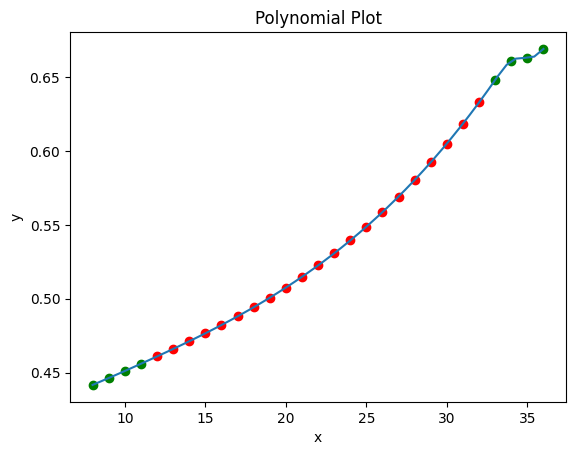

[0, 1, 2, 3, 11, 33, 34, 35]
[0.675, 0.6771818181818182, 0.6793636363636364, 0.6815454545454546, 0.699, 0.75, 0.758, 0.77]


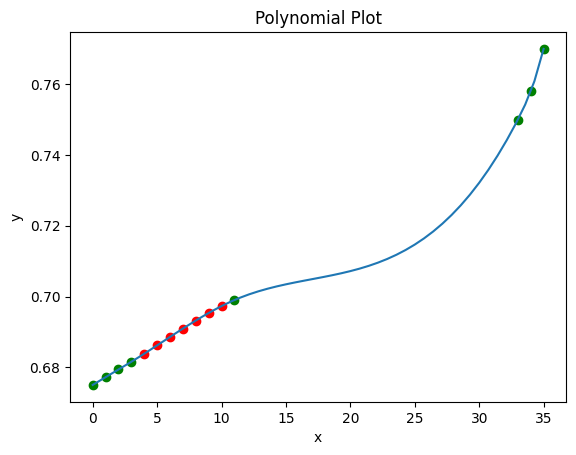

[8, 9, 10, 11, 33, 34, 35, 36]
[0.6931981703802139, 0.6953385747745779, 0.6972904031807866, 0.699, 0.75, 0.758, 0.77, 0.774]


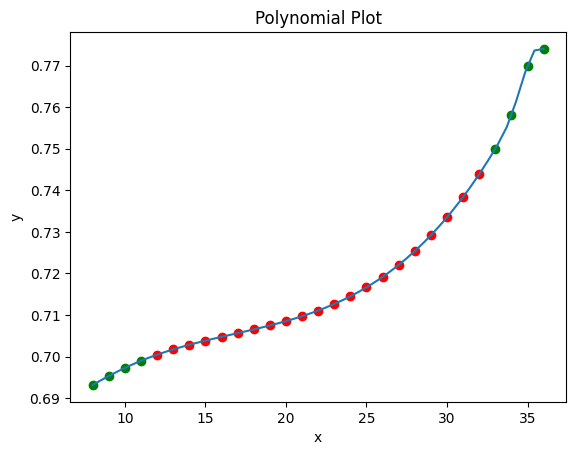

[0, 1, 2, 3, 11, 33, 34, 35]
[0.69, 0.6950909090909091, 0.7001818181818181, 0.7052727272727273, 0.746, 0.733, 0.743, 0.745]


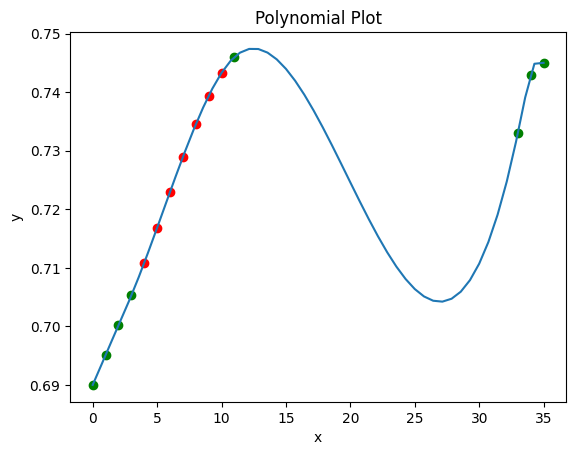

[8, 9, 10, 11, 33, 34, 35, 36]
[0.7344696507020546, 0.7393521401439304, 0.7432855992342327, 0.746, 0.733, 0.743, 0.745, 0.74]


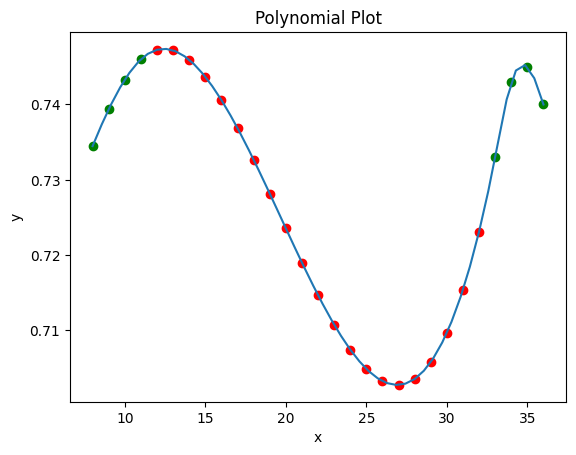

[0, 1, 2, 3, 11, 33, 34, 35]
[0.618, 0.6256363636363637, 0.6332727272727272, 0.6409090909090908, 0.702, 0.742, 0.758, 0.762]


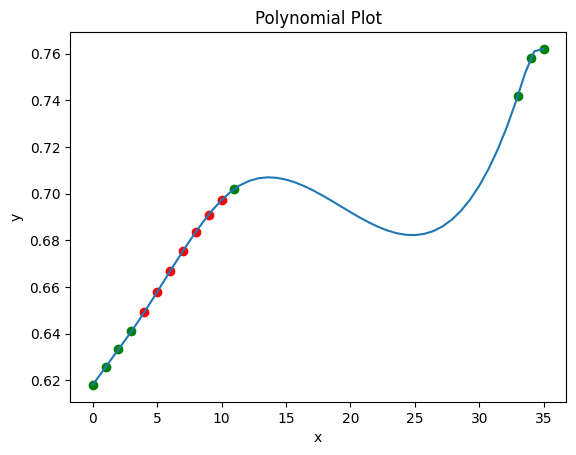

[8, 9, 10, 11, 33, 34, 35, 36]
[0.6835474614992535, 0.6909356318491279, 0.6971936642152401, 0.702, 0.742, 0.758, 0.762, 0.77]


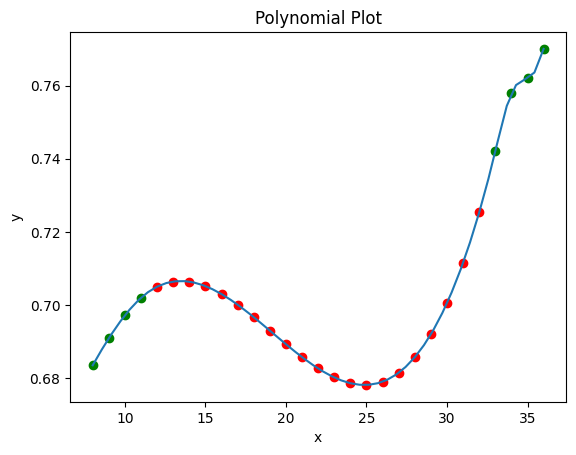

[0, 1, 2, 3, 11, 33, 34, 35]
[0.579, 0.5804545454545454, 0.5819090909090908, 0.5833636363636362, 0.595, 0.666, 0.671, 0.684]


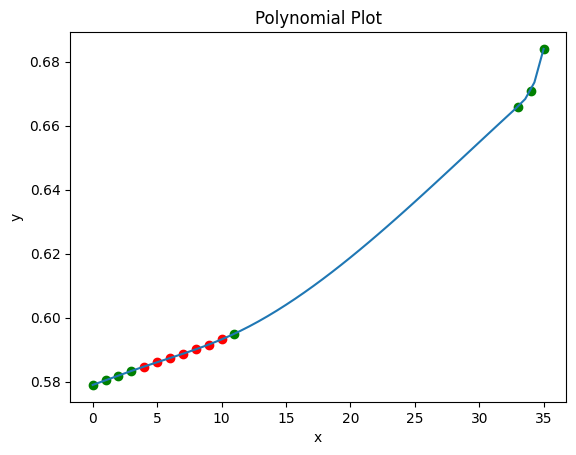

[8, 9, 10, 11, 33, 34, 35, 36]
[0.5901227124064027, 0.5916058640065046, 0.5932192725209646, 0.595, 0.666, 0.671, 0.684, 0.689]


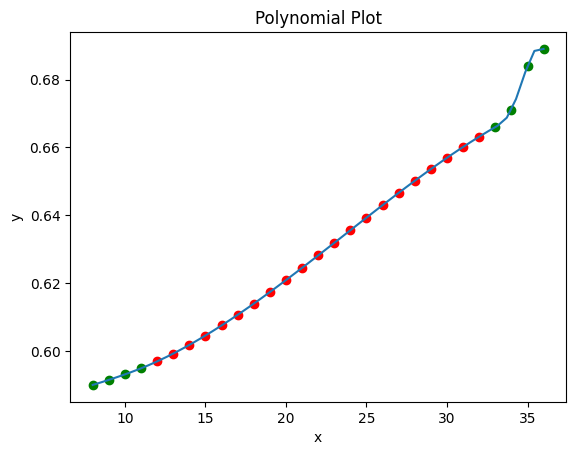

[0, 1, 2, 3, 11, 33, 34, 35]
[0.402, 0.40954545454545455, 0.4170909090909091, 0.42463636363636365, 0.485, 0.673, 0.67, 0.69]


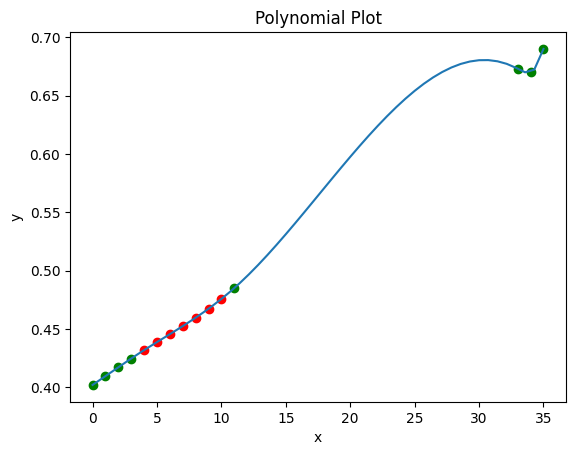

[8, 9, 10, 11, 33, 34, 35, 36]
[0.45961716142704573, 0.46731557201975704, 0.47571046172073156, 0.485, 0.673, 0.67, 0.69, 0.703]


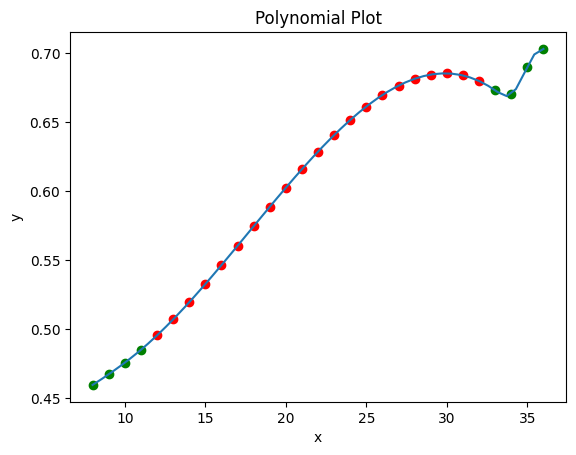

[0, 1, 2, 3, 11, 33, 34, 35]
[0.502, 0.5083636363636364, 0.5147272727272727, 0.521090909090909, 0.572, 0.688, 0.703, 0.715]


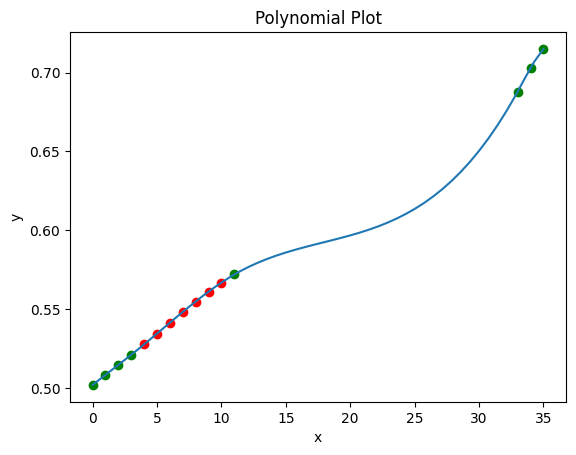

[8, 9, 10, 11, 33, 34, 35, 36]
[0.5548755609003532, 0.5611296810718316, 0.5668851237393964, 0.572, 0.688, 0.703, 0.715, 0.722]


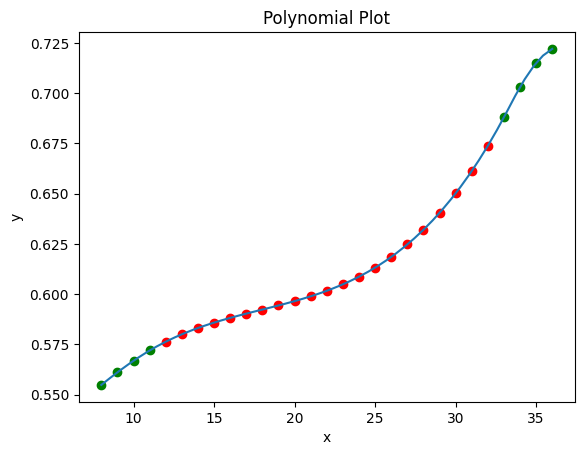

[0, 1, 2, 3, 11, 33, 34, 35]
[0.385, 0.39254545454545453, 0.4000909090909091, 0.40763636363636363, 0.468, 0.66, 0.679, 0.686]


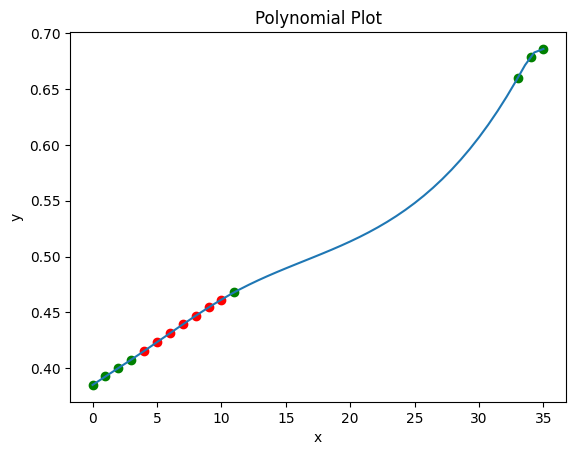

[8, 9, 10, 11, 33, 34, 35, 36]
[0.4469045900535187, 0.4543642261623039, 0.4614330915280155, 0.468, 0.66, 0.679, 0.686, 0.689]


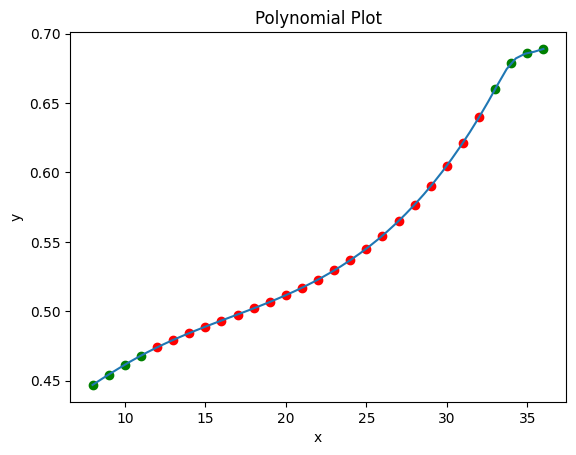

[0, 1, 2, 3, 11, 33, 34, 35]
[0.7, 0.7054545454545454, 0.7109090909090908, 0.7163636363636362, 0.76, 0.772, 0.782, 0.788]


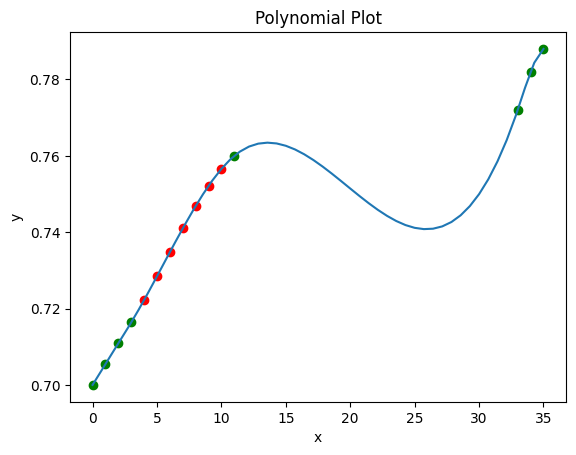

[8, 9, 10, 11, 33, 34, 35, 36]
[0.7468412701302167, 0.7521173286731957, 0.7565806543609908, 0.76, 0.772, 0.782, 0.788, 0.786]


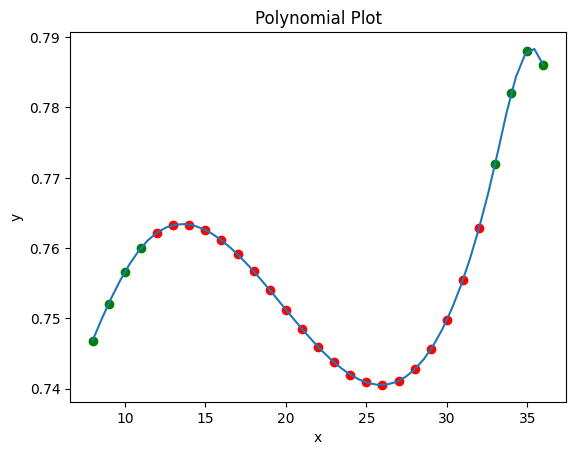

[0, 1, 2, 3, 11, 33, 34, 35]
[0.733, 0.7374545454545455, 0.7419090909090909, 0.7463636363636362, 0.782, 0.762, 0.768, 0.78]


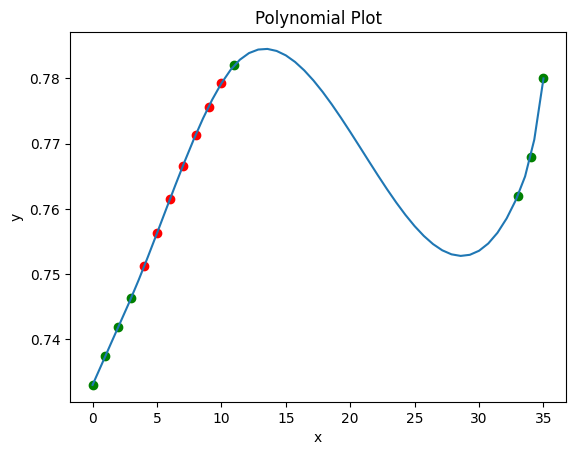

[8, 9, 10, 11, 33, 34, 35, 36]
[0.7713284850912003, 0.7756331015400297, 0.7792550223905049, 0.782, 0.762, 0.768, 0.78, 0.785]


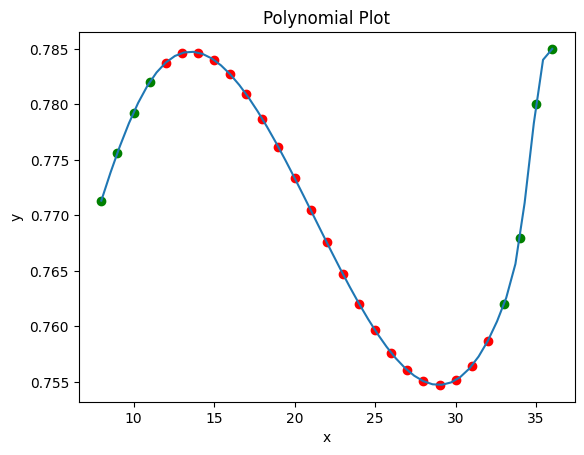

[0, 1, 2, 3, 11, 33, 34, 35]
[0.444, 0.45263636363636367, 0.46127272727272733, 0.46990909090909094, 0.539, 0.695, 0.71, 0.723]


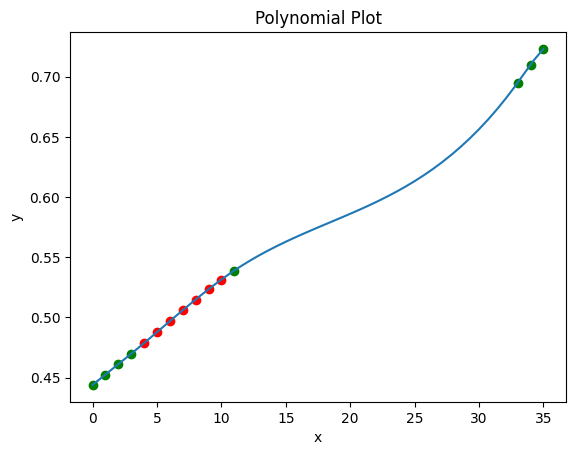

[8, 9, 10, 11, 33, 34, 35, 36]
[0.5148947517323819, 0.523430656181357, 0.5315091238273808, 0.539, 0.695, 0.71, 0.723, 0.733]


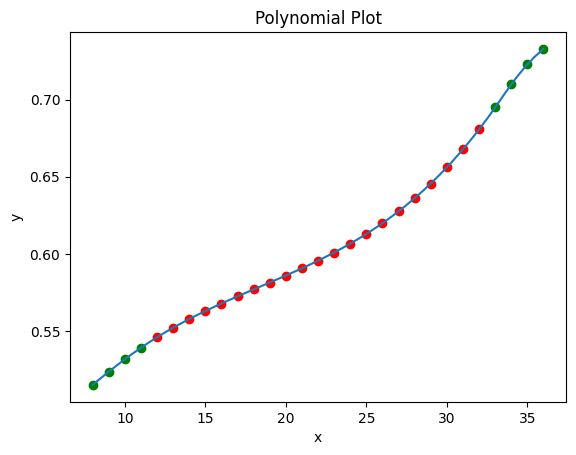

[0, 1, 2, 3, 11, 33, 34, 35]
[0.595, 0.5986363636363636, 0.6022727272727273, 0.6059090909090908, 0.635, 0.694, 0.687, 0.692]


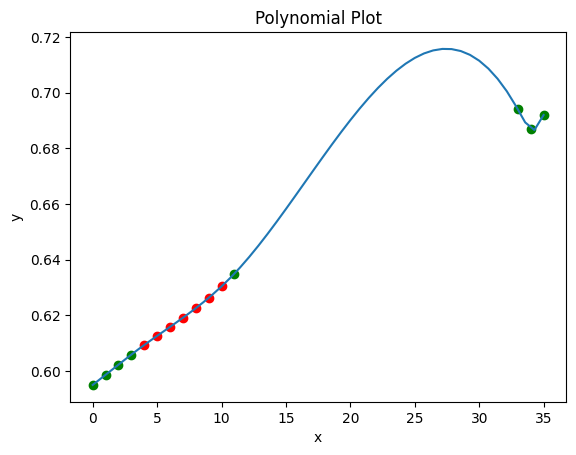

[8, 9, 10, 11, 33, 34, 35, 36]
[0.6225681454108565, 0.6262893144500673, 0.6303966414242546, 0.635, 0.694, 0.687, 0.692, 0.706]


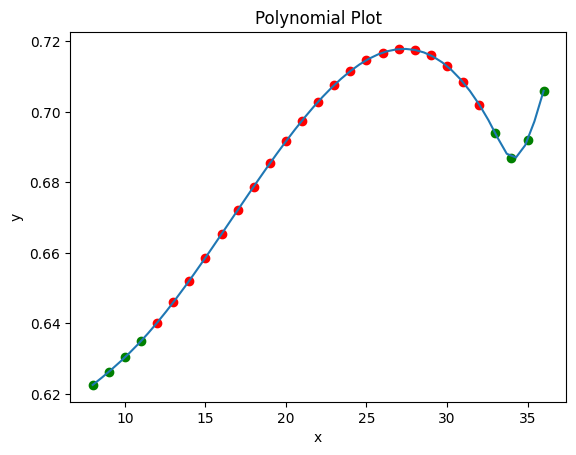

[0, 1, 2, 3, 11, 33, 34, 35]
[0.679, 0.6834545454545455, 0.6879090909090909, 0.6923636363636364, 0.728, 0.738, 0.738, 0.744]


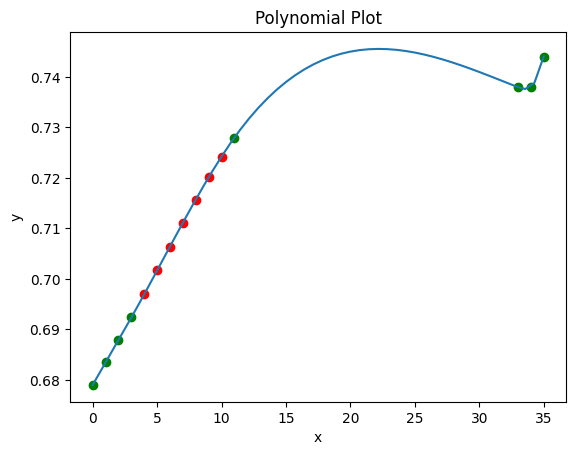

[8, 9, 10, 11, 33, 34, 35, 36]
[0.7157225670804966, 0.7201166199439328, 0.7242352222667202, 0.728, 0.738, 0.738, 0.744, 0.748]


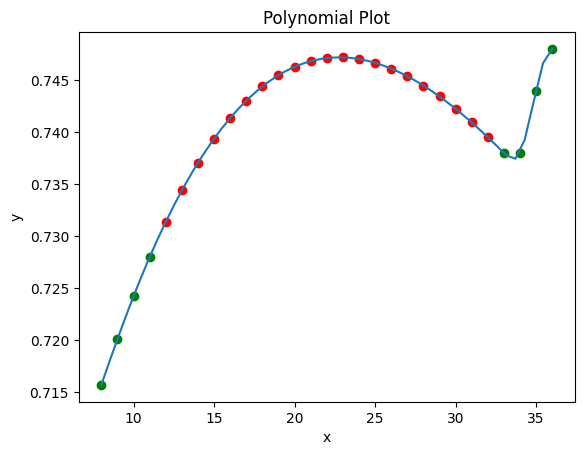

[0, 1, 2, 3, 11, 33, 34, 35]
[0.744, 0.7478181818181818, 0.7516363636363637, 0.7554545454545455, 0.786, 0.763, 0.773, 0.779]


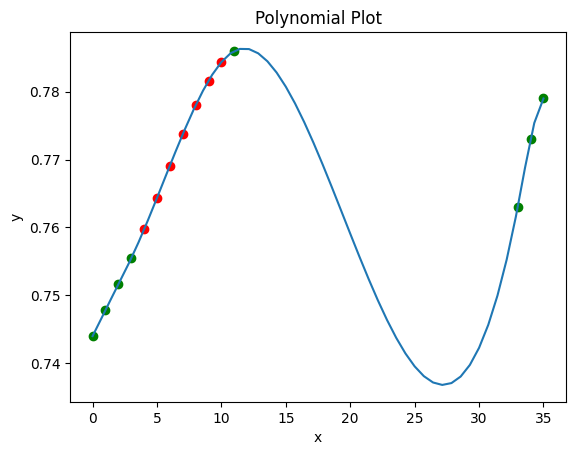

[8, 9, 10, 11, 33, 34, 35, 36]
[0.7779855318806811, 0.7816121297071638, 0.7843663576594945, 0.786, 0.763, 0.773, 0.779, 0.787]


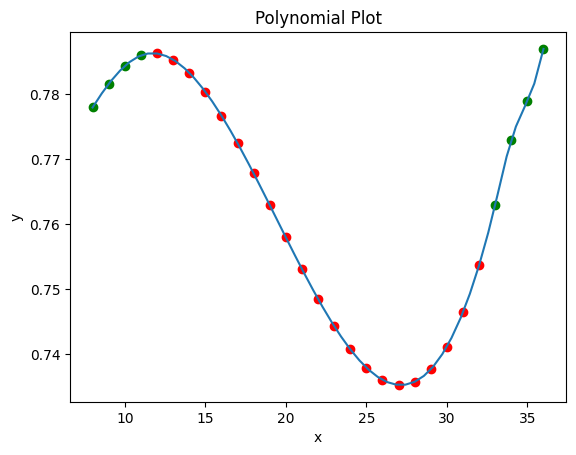

[0, 1, 2, 3, 11, 33, 34, 35]
[0.734, 0.7386363636363636, 0.7432727272727273, 0.7479090909090909, 0.785, 0.792, 0.801, 0.807]


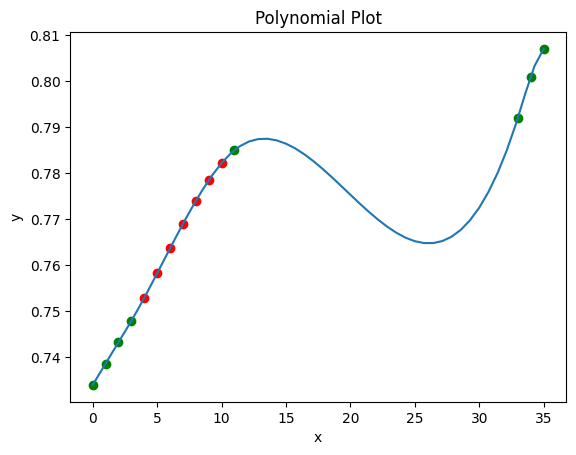

[8, 9, 10, 11, 33, 34, 35, 36]
[0.7739538867095057, 0.7784308060581788, 0.782181702361015, 0.785, 0.792, 0.801, 0.807, 0.809]


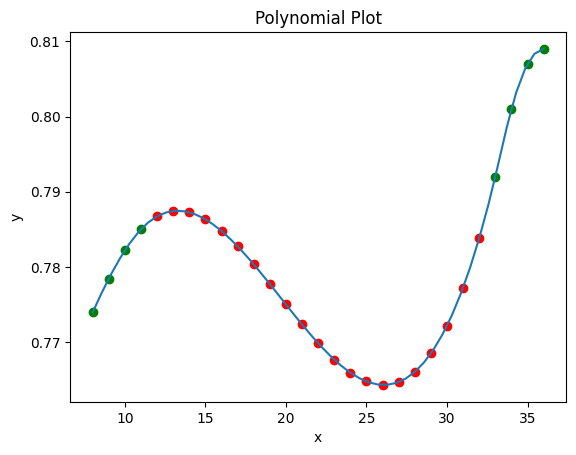

[0, 1, 2, 3, 11, 33, 34, 35]
[0.477, 0.48263636363636364, 0.48827272727272725, 0.4939090909090909, 0.539, 0.684, 0.683, 0.696]


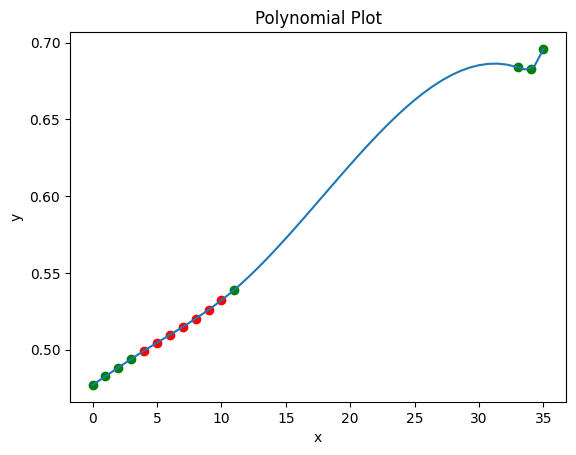

[8, 9, 10, 11, 33, 34, 35, 36]
[0.5202169049829493, 0.5259576352228736, 0.5321735945255519, 0.539, 0.684, 0.683, 0.696, 0.697]


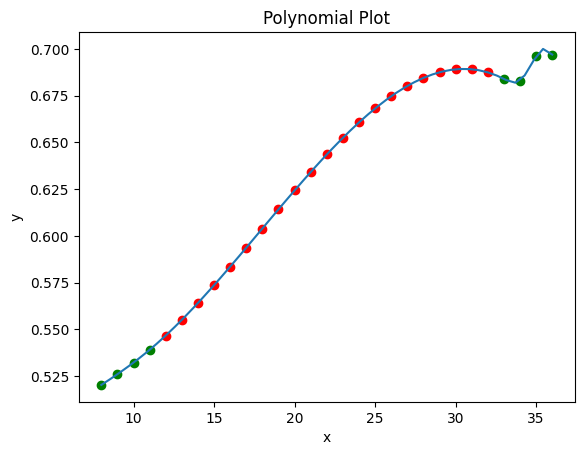

[0, 1, 2, 3, 11, 33, 34, 35]
[0.728, 0.7333636363636363, 0.7387272727272727, 0.7440909090909091, 0.787, 0.812, 0.818, 0.825]


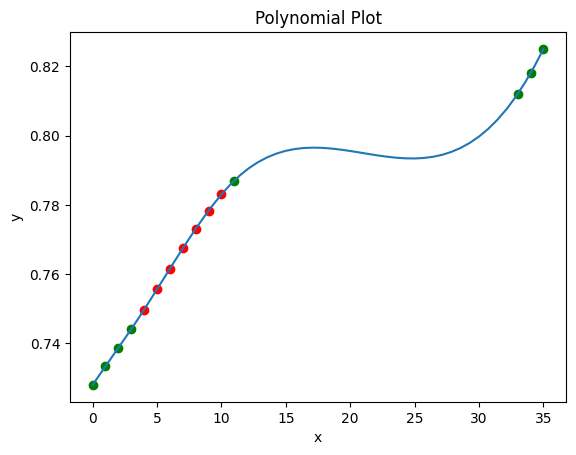

[8, 9, 10, 11, 33, 34, 35, 36]
[0.7730371055114624, 0.7782822289778037, 0.7829877088111795, 0.787, 0.812, 0.818, 0.825, 0.823]


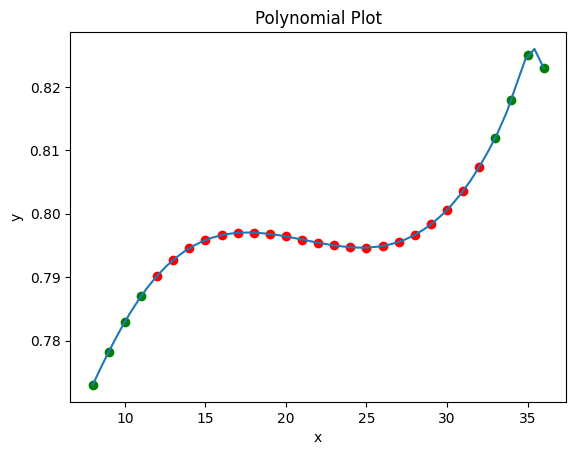

,Acre,Alagoas,Amazonas,Amapá,Bahia,Ceará,Distrito Federal,Espírito Santo,Goiás,Maranhão,...,Piauí,Paraná,Rio de Janeiro,Rio Grande do Norte,Rondônia,Roraima,Rio Grande do Sul,Santa Catarina,Sergipe,São Paulo
Ano,,,,,,,,,,,,,,,,,,,,,
1980,0.506000,0.410000,0.608000,0.582000,0.515000,0.440000,0.751000,0.673000,0.660000,0.405000,...,0.385000,0.700000,0.733000,0.444000,0.595000,0.679000,0.744000,0.734000,0.477000,0.728000
1981,0.513091,0.415818,0.612545,0.591545,0.516364,0.447000,0.756000,0.675818,0.665636,0.409636,...,0.392545,0.705455,0.737455,0.452636,0.598636,0.683455,0.747818,0.738636,0.482636,0.733364
1982,0.520182,0.421636,0.617091,0.601091,0.517727,0.454000,0.761000,0.678636,0.671273,0.414273,...,0.400091,0.710909,0.741909,0.461273,0.602273,0.687909,0.751636,0.743273,0.488273,0.738727
1983,0.527273,0.427455,0.621636,0.610636,0.519091,0.461000,0.766000,0.681455,0.676909,0.418909,...,0.407636,0.716364,0.746364,0.469909,0.605909,0.692364,0.755455,0.747909,0.493909,0.744091
1984,0.534419,0.432880,0.626530,0.621206,0.520088,0.467849,0.771448,0.684381,0.682897,0.423495,...,0.415382,0.722235,0.751168,0.478780,0.609348,0.696959,0.759720,0.752917,0.499302,0.749731
1985,0.541612,0.437983,0.631710,0.632621,0.520783,0.474574,0.777267,0.687397,0.689174,0.428041,...,0.423293,0.728449,0.756261,0.487844,0.612623,0.701671,0.764354,0.758233,0.504494,0.755599
1986,0.548819,0.442979,0.636985,0.644312,0.521379,0.481258,0.783206,0.690442,0.695546,0.432572,...,0.431258,0.734776,0.761448,0.496971,0.615845,0.706422,0.769108,0.763648,0.509620,0.761542
1987,0.556010,0.448088,0.642159,0.655711,0.522079,0.487985,0.789017,0.693457,0.701818,0.437118,...,0.439165,0.740984,0.766535,0.506032,0.619123,0.711131,0.773735,0.768958,0.514816,0.767406
1988,0.563155,0.453527,0.647042,0.666248,0.523088,0.494840,0.794451,0.696380,0.707794,0.441706,...,0.446905,0.746841,0.771328,0.514895,0.622568,0.715723,0.777986,0.773954,0.520217,0.773037


In [18]:
df = read_csv_replace_missing_by_polynomial_2('idh_para_interpolacao.csv')
df = df.set_index('Ano')
df

In [19]:
def export_interpolated_columns_as_csv(df, index):
    for column in df.columns:
        column_data = df[column]
        filename = f"{column}_interpolated.csv"
        column_data.to_csv(filename, index_label=index)

In [20]:
export_interpolated_columns_as_csv(df, 'Ano')